In [1]:
import pandas as pd
import numpy as np
from rdflib import Graph

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
path = 'dataset/'

g1 = Graph()
g1.parse(path+"TKG_1.ttl", format="ttl")

g2 = Graph()
g2.parse(path + "TKG_2.ttl", format="ttl")

g3 = Graph()
g3.parse(path + "TKG_3.ttl", format="ttl")

<Graph identifier=Nd279db3f54b04647bf9c92dc548a9173 (<class 'rdflib.graph.Graph'>)>

In [3]:
from rdflib.plugins.sparql.processor import SPARQLResult

def sparql_results_to_df(results: SPARQLResult) -> pd.DataFrame:
    """
    Export results from an rdflib SPARQL query into a `pandas.DataFrame`,
    using Python types. See https://github.com/RDFLib/rdflib/issues/1179.
    """
    return pd.DataFrame(
        data=([None if x is None else x.toPython() for x in row] for row in results),
        columns=[str(x) for x in results.vars],
    )


def query_treatment_ddi_plot(target):
    query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX ex: <http://example/#> 

    select distinct ?treatment  (count(?ddi) as ?count_ddi)
    where {
        ?treatment ex:belong_to """+target+""" .
        optional {?treatment ex:hasInteraction ?ddi .}
        }
        GROUP BY ?treatment
        ORDER BY desc(?count_ddi)
        """
    return query


def density_ddi(df_plot, target, r1=None, r2=None):
    col = [mcolors.CSS4_COLORS['rosybrown'], mcolors.CSS4_COLORS['lightcoral'], mcolors.CSS4_COLORS['brown']]
    fig, ax = plt.subplots()
    sns.kdeplot(data=df_plot['KG1'], ax=ax, fill=True, shade=True,
                cut=0, bw_adjust=.4, label='${\cal{T\_KG}}_{basic}$')
    sns.kdeplot(data=df_plot['KG2'], ax=ax, fill=True, shade=True,
                cut=0, bw_adjust=.4, label='$\cal{T\_KG}$')
    sns.kdeplot(data=df_plot['KG3'], ax=ax, fill=True, shade=True,
               cut=0, bw_adjust=.4, label='${\cal{T\_KG}}_{random}$')

    ax.legend( loc='upper right') #bbox_to_anchor=(1.02, 1.02),
    ax.set_xlabel('Count of DDIs')
    

    plt.yticks(r1)
    plt.xticks(r2)
    
    plt.title('Density of DDIs by '+target+' Treatment')
    plt.tight_layout()
    plt.savefig('Embeddings/Plots/Density_'+target+'_Treatment.pdf', format='pdf', bbox_inches='tight')


def distribution_ddi(df_plot, target):
    fig, ax = plt.subplots()
    sns.lineplot(data=df_plot['KG1'], ax=ax, dashes=False, marker='o', label='${\cal{T\_KG}}_{basic}$')
    sns.lineplot(data=df_plot['KG2'], ax=ax, dashes=False, marker='^', label='$\cal{T\_KG}$')
    ax.set_xlabel(target+' Treatments')
    ax.set_ylabel('Count of DDIs')
    plt.title('Distribution of DDIs by '+target+' Treatment')
    plt.savefig('Embeddings/Plots/Distribution_DDI_'+target+'_Treatment.pdf', format='pdf', bbox_inches='tight')

## Density of DDIs by Effective Treatment in each KG

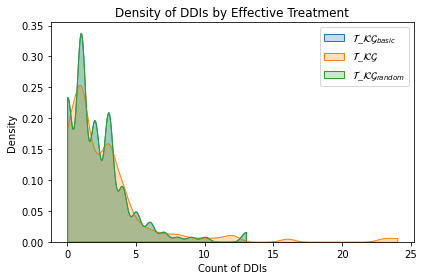

In [4]:
df_plot = pd.DataFrame(columns=['KG1', 'KG2', 'KG3'])

qres = g1.query(query_treatment_ddi_plot('ex:effective'))
df_effective = sparql_results_to_df(qres)
df_plot['KG1']=list(df_effective.count_ddi)

qres = g2.query(query_treatment_ddi_plot('ex:effective'))
df_effective = sparql_results_to_df(qres)
df_plot['KG2']=list(df_effective.count_ddi)

qres = g3.query(query_treatment_ddi_plot('ex:effective'))
df_effective = sparql_results_to_df(qres)
df_plot['KG3']=list(df_effective.count_ddi)

density_ddi(df_plot, 'Effective')

## Distribution of DDIs by Effective Treatment

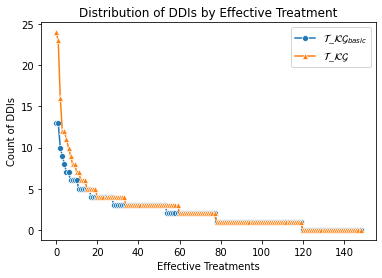

In [5]:
distribution_ddi(df_plot, 'Effective')

## Density of DDIs by Low_Effect Treatment in each KG

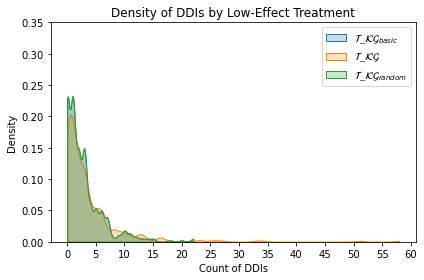

In [6]:
df_plot = pd.DataFrame(columns=['KG1', 'KG2', 'KG3'])

qres = g1.query(query_treatment_ddi_plot('ex:low_effect'))
df_low_effect = sparql_results_to_df(qres)
df_plot['KG1']=list(df_low_effect.count_ddi)

qres = g2.query(query_treatment_ddi_plot('ex:low_effect'))
df_low_effect = sparql_results_to_df(qres)
df_plot['KG2']=list(df_low_effect.count_ddi)

qres = g3.query(query_treatment_ddi_plot('ex:low_effect'))
df_low_effect = sparql_results_to_df(qres)
df_plot['KG3']=list(df_low_effect.count_ddi)

density_ddi(df_plot, 'Low-Effect', r1=np.arange(0, 0.36, 0.05, float), r2=np.arange(0, 65, 5, float))

## Distribution of DDIs by Low_Effect Treatment

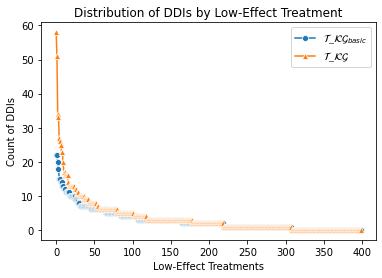

In [7]:
distribution_ddi(df_plot, 'Low-Effect')